In [1]:
import pandas as pd 
df = pd.read_json("../datasets/ai_coordination/dataset_294_selection.json")

In [21]:
from transformers import AutoModelForCausalLM
import torch
# The model is loaded in 8-bit on available GPUs using the bitsandbytes library integrated in HF Transformers
# This will make the model much smaller for inference purposes, but attributions are not guaranteed to match those
# of the full-precision model.
model_name ="meta-llama/Llama-2-7b-chat-hf"# "gpt2" #
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=False, torch_dtype=torch.float16, device_map="auto")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
import inseq
import copy
#model = inseq.load_model("gpt2", "integrated_gradients")
layer_num = len(model.model.layers)
out_all = {}

for layer in range(layer_num):
    attrib_model = inseq.load_model(
            model,
            "layer_gradient_x_activation",#"attention",#,
            tokenizer=model_name,
            target_layer=model.model.layers[layer].mlp
            #target_layer=model.transformer.h[layer].mlp , 
        )
    # Uses Huggingface generate method + automatically decodes outputs
    #natural_generation = model.generate("The manager went home because", max_new_tokens=4)[0]

    #print("Natural output:", natural_generation)

    # Why "he" rather than "she"?
    out = attrib_model.attribute(
        input_texts=["The manager went home because", "The manager went home because"],
        # generated_texts is used to force the attribution of the specified texts
        generated_texts=["The manager went home because he was sick.", "The manager went home because she was sick."],
    # step_scores=["probability"],
    )
    temp =out#.aggregate()
    out_all[layer] = copy.deepcopy(temp)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Attributing with layer_gradient_x_activation...: 100%|██████████| 10/10 [00:00<00:00, 21.54it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Attributing with layer_gradient_x_activation...: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Attributing with layer_gradient_x_activation...: 100%|██████████| 10/10 [00:00<00:00, 22.60it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Attributing with layer_gradient_x_activation...: 100%|██████████| 10/10 [00:00<00:00, 22.97it/s]
Asking to truncate to max_length but no maximum 

In [76]:

list(out_dict["target_attributions"][last_token].values())[:-1]

[0.16752149164676666,
 0.18006713688373566,
 0.15116280317306519,
 0.10320014506578445,
 0.11511267721652985,
 0.1274862140417099,
 0.0423324778676033,
 0.031993258744478226,
 0.08112367242574692]

In [77]:
prompts = ["The manager went home because he was sick.", "The manager went home because she was"]
scores = {}
for attribution in range(len(prompts)):
    for layer_idx in range(layer_num):
        curr_out = out_all[layer_idx]#FeatureAttributionOutput.load(f"../data/cat_outputs/layer_{layer_idx}.json")
        out_dict = out_dict = curr_out[attribution].get_scores_dicts()#curr_out.get_scores_dicts(do_aggregation=False)[attribution]

        last_token = list(out_dict['target_attributions'].keys())[-1]


        scores[layer_idx] = list(out_dict["target_attributions"][last_token].values())[:-1]

        prefix_tokens = list(out_dict["target_attributions"][last_token].keys())
        attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])

# Attributed prefix tokens x layers
attributions_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
"(0, <s>)",0.200620,0.507484,0.038733,0.006110,0.087294,0.006440,0.005694,0.005550,0.005778,0.006592,...,0.008913,0.014513,0.009807,0.015455,0.012550,0.023545,0.014455,0.032840,0.122803,0.0
"(1, ▁The)",0.183758,0.103220,0.105056,0.072836,0.128164,0.086030,0.088149,0.074096,0.073915,0.082949,...,0.049038,0.047774,0.045344,0.041618,0.048036,0.032254,0.054782,0.041907,0.045182,0.0
"(2, ▁manager)",0.142991,0.095281,0.201158,0.201840,0.126512,0.129900,0.125960,0.108640,0.100304,0.086011,...,0.101601,0.104167,0.100980,0.110274,0.098490,0.107338,0.038881,0.027451,0.020861,0.0
"(3, ▁went)",0.095236,0.064820,0.105843,0.141457,0.097964,0.136785,0.110334,0.106545,0.103469,0.080884,...,0.090429,0.089604,0.094256,0.089517,0.091283,0.090348,0.051550,0.035809,0.030209,0.0
"(4, ▁home)",0.104536,0.083090,0.227448,0.208144,0.140254,0.135455,0.147242,0.143375,0.135479,0.112189,...,0.113998,0.118343,0.139817,0.119057,0.112250,0.101118,0.114914,0.094777,0.037413,0.0
"(5, ▁because)",0.137314,0.051115,0.135129,0.155892,0.192780,0.239500,0.221117,0.243425,0.251081,0.260814,...,0.069441,0.075303,0.067066,0.075040,0.081794,0.112426,0.109694,0.123367,0.056152,0.0
"(6, ▁she)",0.032608,0.022377,0.032297,0.042908,0.060939,0.054602,0.073848,0.075618,0.072212,0.075666,...,0.054333,0.052422,0.057777,0.053840,0.056398,0.056653,0.066538,0.033737,0.031329,0.0
"(7, ▁was)",0.027201,0.010235,0.020872,0.021383,0.022921,0.029998,0.036137,0.034695,0.036794,0.046732,...,0.068636,0.055002,0.055662,0.049776,0.057159,0.033507,0.028848,0.026157,0.013549,0.0
"(8, ▁sick)",0.075735,0.062379,0.133466,0.149430,0.143171,0.181289,0.191519,0.208056,0.220968,0.248164,...,0.443610,0.442872,0.429291,0.445423,0.442039,0.442812,0.520338,0.583955,0.642502,1.0


In [78]:
## sum column-wise dataframe
attributions_df.sum(axis=0)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
dtype: float64

In [62]:
#c.attributions

In [54]:
#out_all[layer_idx]#.show()

In [63]:
#out_dict[0].keys()

In [64]:
#out_dict['target_attributions'][last_token]

In [40]:
#out.show()

In [41]:
#model.cuda()

In [ ]:
#model.transformer.h[layer].mlp

In [42]:
#model.model.layers[0].mlp

In [28]:
import inseq
import copy
# Important: adding a space after the prompt would cause problems since the final space would be tokenized separately
prompt = "The Eiffel Tower is located in the city of"
true_answer = "The Eiffel Tower is located in the city of Paris"#, France."
false_answer = "The Eiffel Tower is located in the city of Rome"#, Italy."

out_all = {}
# GPT-2 XL is a Transformer model with 48 layers
layer_num = 12
for layer in range(layer_num):
    attrib_model = inseq.load_model(
        model,
        "layer_gradient_x_activation",#"attention",#,
        tokenizer=model_name,
        target_layer=model.model.layers[layer].mlp
        #target_layer=model.transformer.h[layer].mlp , 
    )
    
    # Contrastive attribution of true vs false answer
    out = attrib_model.attribute(
        prompt,
        true_answer,
        attributed_fn="contrast_prob_diff",
        contrast_targets=false_answer,
        step_scores=["contrast_prob_diff"],
        show_progress=False,
    )
    # Save aggregated attributions to disk

    ## NEEDS TO BE SAVED FOR LAYERS --> LATER DISK PROBABLY NECCESSARY 
    temp =out.aggregate()
    out_all[layer] = copy.deepcopy(temp)
    #out.save(f"../data/cat_outputs/layer_{layer}.json", overwrite=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
No target alignments were provided for the contrastive target. Use e.g. 'contrast_targets_alignments=[(0,1), ...] to provide them in model.attribute
Filling missing position with right-aligned 1:1 position alignments.
/home/paul/miniconda3/envs/llm_updated/lib/python3.9/site-packages/inseq/utils/contrast_utils.py:148: UserWarning: Contrastive inputs do not match original inputs when using a contrastive attributed function.
By default we force the original inputs to be used (i.e. only the contrastive predicted target is different).
This is a requirement for gradient-based attribution method, as contrastive inputs don't participate in gradient computation.
For attribution methods with less stringent requirements, set --contrast_force_inputs to True to use the contrastive inputs for attribution instead.
  warnings.warn(
Asking to truncate to max_leng

In [25]:
out_dict['target_attributions'].keys()



dict_keys([(11, 'ĠRome → ĠParis')])

In [7]:
#out_all[layer]

In [29]:
scores = {}
change_of_interest = (12, '▁Rome → ▁Paris') #(11, 'ĠRome → ĠParis')#(14, '.') # 
for layer_idx in range(layer_num):
    curr_out = out_all[layer_idx]#FeatureAttributionOutput.load(f"../data/cat_outputs/layer_{layer_idx}.json")
    out_dict = curr_out.get_scores_dicts(do_aggregation=False)[0]
    scores[layer_idx] = list(out_dict["target_attributions"][change_of_interest].values())[:-1]

prefix_tokens = list(out_dict["target_attributions"][change_of_interest].keys())
attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])

# Attributed prefix tokens x layers
attributions_df

,0,1,2,3,4,5,6,7,8,9,10,11
"(0, <s>)",0.253500,0.438221,0.031767,0.006029,0.076875,0.006733,0.005646,0.005501,0.006045,0.005700,0.007195,0.007846
"(1, ▁The)",0.124495,0.071356,0.084218,0.059973,0.118395,0.089628,0.105383,0.082034,0.051392,0.055455,0.055647,0.036554
"(2, ▁E)",0.027287,0.017062,0.013553,0.018269,0.029036,0.013308,0.013475,0.008901,0.009534,0.009180,0.012227,0.006569
"(3, iff)",0.047983,0.057161,0.123149,0.089414,0.063746,0.072279,0.085407,0.075473,0.071976,0.075465,0.071874,0.070922
"(4, el)",0.039420,0.040166,0.138130,0.088968,0.050908,0.046758,0.047862,0.049070,0.044053,0.039432,0.037954,0.034933
"(5, ▁Tower)",0.063502,0.045343,0.116700,0.166489,0.114754,0.101301,0.101359,0.096489,0.085879,0.074061,0.067988,0.064955
"(6, ▁is)",0.084712,0.026813,0.040630,0.043836,0.040980,0.068308,0.060414,0.064518,0.077713,0.068370,0.066987,0.055017
"(7, ▁located)",0.086139,0.067742,0.083240,0.108000,0.107998,0.145699,0.133231,0.132995,0.140747,0.150217,0.140153,0.131765
"(8, ▁in)",0.036838,0.036368,0.083885,0.086437,0.096098,0.114412,0.101249,0.115412,0.121906,0.137206,0.106323,0.106217
"(9, ▁the)",0.035931,0.080875,0.034319,0.037504,0.050200,0.037324,0.030732,0.044259,0.043248,0.041840,0.048414,0.058661


In [30]:
# import pandas as pd

# from inseq import FeatureAttributionOutput

# scores = {}
# change_of_interest = (13, 'ĠItaly → ĠFrance')#(11, 'ĠRome → ĠParis') # (12, '▁Rome → ▁Paris')
# for layer_idx in range(layer_num):
#     curr_out = out_all[layer_idx]#FeatureAttributionOutput.load(f"../data/cat_outputs/layer_{layer_idx}.json")
#     out_dict = curr_out.get_scores_dicts(do_aggregation=False)[0]
#     scores[layer_idx] = list(out_dict["target_attributions"][change_of_interest].values())[:-1]

# prefix_tokens = list(out_dict["target_attributions"][change_of_interest].keys())
# attributions_df = pd.DataFrame(scores, index=prefix_tokens[:-1])

# # Attributed prefix tokens x layers
# attributions_df

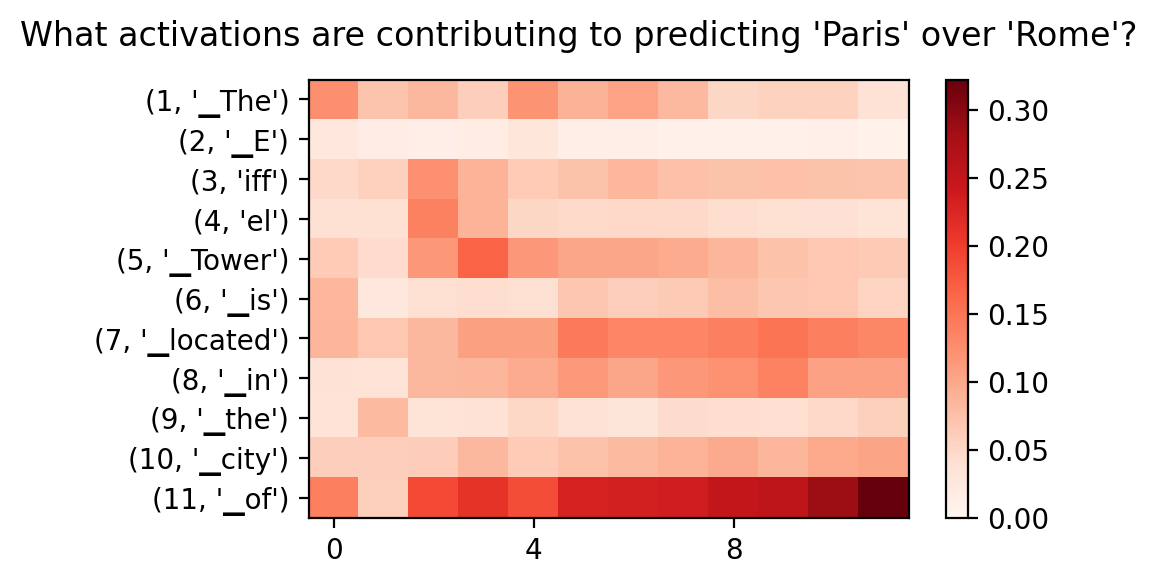

In [34]:
from matplotlib import pyplot as plt

#filename = "../img/cat_example_plot.png"
values = attributions_df.values[1:] #skipping the BOS token
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
plt.subplots_adjust(bottom=0.15, left=0.275)
h = ax.pcolor(
    values, #skipping the first row
    cmap="Reds",
    vmin=0,
    vmax=values.max(),
)
ax.invert_yaxis()
ax.set_yticks([0.5 + i for i in range(len(values))])
ax.set_xticks([0.5 + i for i in range(0, values.shape[1], 4)])
ax.set_xticklabels(list(range(0, layer_num, 4)))
ax.set_yticklabels(attributions_df.index[1:])
cb = plt.colorbar(h)#, ticks=[0, 0.15, 0.3, 0.45, 0.6, 0.75])
fig.suptitle("What activations are contributing to predicting 'Paris' over 'Rome'?")
#plt.savefig(filename)
plt.show()